###**ATOC4500 Data Science Lab: Final Project**
###**Assessing the Correlation Between Shortwave and Longwave Radiance**
###Author: Fergus Mackenzie, fema1012@colorado.edu###
###last updated: April 21, 2022###

**>>>> This code is available on github at (insert URL)**

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

**Introduction**
I have been working with Peter Pilewskie, a scientist at LASP and ATOC, on an independent research study this semester on the topic of the Earth Radiation Budget. The Earth Radiation Budget describes the balance between the energy that enters and exits the Earth system (Earth and atmosphere). This is a key climate variable that can directly describe how the climate is changing or expected to change. Radiative balance occurs when the amount of incoming solar radiaition is equal to the sum of outgoing longwave radiaiton and reflected shortwave radiation. However, if there is an imbalance between these two quantities, than the Earth system will change to reflect this imbalance. For example, if there is more energy coming into the Earth system than exiting, you can expect global warming to continue. Presently, there is around a 0.5 W/m2 (incoming>outgoing) imbalance in the Earth Radiation Budget (depending on who you ask). (Loeb et. al, 2012)

Due to the Earth Radiation Budget being such an important climate variable, the understanding of the radiative fluxes at the top of the atmosphere is critical. NASA's mission CERES is a collection of satellite based instruments designed to monitor the transfer of energy at the top of the atmosphere with a high spatial resolution and global coverage (reference 2). Two important measurements that they make are the outgoing reflected shortwave (SW) radiance and the outgoing emitted longwave (LW) radiance. Radiance is the energy intensity as measured from a single direction (a unit also known as a steradian), with the units (Wm-2sr-1). These variables, along with precise measurements of the incoming solar radiation, provide a clear picture of the Earth Radiation Budget through space and time. 

During my independent research study, I have been downloading and analyzing data from the CERES satellite from NASA's Earthdata Atmospheric Science Data Center website - https://asdc.larc.nasa.gov/data/. The CERES CER_SSF_NPP-FM5-VIIRS_Edition1A data product (reference 3) has massive .hdf files, each on the order of 70 MB. I am using this same dataset for my ATOC4500 project. Each  .hdf file covers 1 hour of CERES measurements and has over 200 variables in it. Since I am only interested in SW radiance and LW radiance, I had to manually construct a small dataset that only contains the variables I need. First I downloaded a month's worth of data (about 740 .hdf files each covering one hour), then I extracted only th evariables that interest me into the pandas dataframe, and finally saved the dataframe to a .csv file. 

With the hope of keeping the scope of my data science project small, I will simply be practicing testing a hypothesis. I will calculate the correlation between SW radiance and LW radiance and perform a t-test to determine the the correlation is not zero (hopefully rejecting the null hypothesis that the correlation is 0). The hypothesis is that you can use SW radiance to predict LW radiance, because a higher reflected radiance means less absorbed, which leads to colder tempertures and lower emitted LW radiance. 

# Goal: assess the correlation between two variables - LW radiance and SW radiance.

Hypothesis: there is a negative correlation between SWrad and LWrad at 95% confidence.
You can use SW reflected to predict LW emitted (less absorbed radiation = colder surface emitting temperature).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib.cm as cm
#from matplotlib_scalebar.scalebar import ScaleBar
from scipy import stats
from google.colab import files

In [2]:
#We need to install geopandas for making the map (maps are fun)
!pip install geopandas

     |████████████████████████████████| 1.0 MB 4.0 MB/s 
     |████████████████████████████████| 6.3 MB 15.8 MB/s 
     |████████████████████████████████| 16.7 MB 342 kB/s 


In [3]:
import fiona
import geopandas as geo

###**Step 1: Read in data**

The final dataset that I am analyzing for this project has CERES SW and LW radiance measurements at nadir for the entire month of January 2019. "At nadir" means I am only including measurements directly below the satellite, or at a viewing zenith angle (VZA) close to zero. Other important variables that are included in the dataframe are the Latitude and Longitude of the point of measurement and the solar zenith angle (SZA) at the surface at the point of measurement. The Times_Julian variable describes the time of measurement in what's called Julain Time, which is a continuous count of days and fractions since noon Universal Time on January 1, 4713 BCE. The File_ID variable describes which hourly datafile the data came from, which is another way of knowing the day and hour of the data.

In [4]:
### upload file 201901.csv
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))#

Saving 201901.csv to 201901.csv
User uploaded file "201901.csv" with length 20673479 bytes


We have 

###**Step 2: Munge data**

The only processing step that we need to do restrict the SZA < 60, meaning the sun will be at least 30% up from the horizon. We want to make sure that it is daytime so that reflected SW radiance is not zero. 

In [5]:
#1. Build data set
df = pd.read_csv("201901.csv")

#Get rid of bad values (missing data values are represented as 3.4028235e+38)
df = df.loc[(df.SWrad != 3.4028235e+38) & (df.LWrad != 3.4028235e+38)]

#Restrict data based on SZA (solar zenith angle)
df = df.loc[df.SZA < 60]

df

,Times_Julian,Longitude,Latitude,SWrad,LWrad,VZA,SZA,TOA_Rad,File_ID
122,2.458485e+06,49.959000,75.292740,152.11803,67.457550,0.144158,59.370800,716.98140,2019010100
123,2.458485e+06,48.167970,74.662430,145.64005,68.031600,0.143599,58.675190,731.62990,2019010100
124,2.458485e+06,46.511337,74.019650,112.21323,64.185260,0.144110,57.980595,746.14935,2019010100
125,2.458485e+06,44.977203,73.365970,150.03287,64.726270,0.143198,57.287506,760.52800,2019010100
126,2.458485e+06,43.551636,72.702545,125.76494,68.757080,0.144300,56.595480,774.77360,2019010100
...,...,...,...,...,...,...,...,...,...
208236,2.458515e+06,19.984100,-38.369890,75.79297,65.316120,0.132600,56.555573,772.51044,2019013123
208237,2.458515e+06,19.735184,-39.137543,84.62327,69.943000,0.132531,57.272903,757.80710,2019013123
208238,2.458515e+06,19.482086,-39.904620,82.95744,72.409310,0.132628,57.991090,742.96740,2019013123
208239,2.458515e+06,19.224442,-40.671364,130.65842,58.887997,0.132299,58.710308,727.98920,2019013123


**Look at the data**

In [6]:
#Print of values ranges and means/stds of two variables of interest (SW radiance and LW radiance)

print('Veiwing Zenith Angles range = ', np.min(df.VZA), ' - ', np.max(df.VZA))
print('Solar Zenith Angle range = ', np.min(df.SZA), ' - ', np.max(df.SZA))
print('SWrad range = ', np.min(df.SWrad), ' - ', np.max(df.SWrad))
print('LWrad range = ', np.min(df.LWrad), ' - ', np.max(df.LWrad))
print('Latitude range = ', np.min(df.Latitude), ' - ', np.max(df.Latitude))


print('')
print('SW mean: ', df.SWrad.mean())
print('LW mean: ', df.LWrad.mean())
print('SW Standard deviation: ', df.SWrad.std())
print('LW Standard deviation: ', df.LWrad.std())
print('Data not standardized')

Veiwing Zenith Angles range =  0.00028141137  -  0.15858367
Solar Zenith Angle range =  19.545073  -  59.99987
SWrad range =  10.030726  -  347.57806
LWrad range =  24.87127  -  135.22745
Latitude range =  -41.98614  -  75.80766

SW mean:  88.36022115233759
LW mean:  82.06650157144871
SW Standard deviation:  57.965904072286904
LW Standard deviation:  15.610969360745504
Data not standardized


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 10 Text major ticklabel objects>)

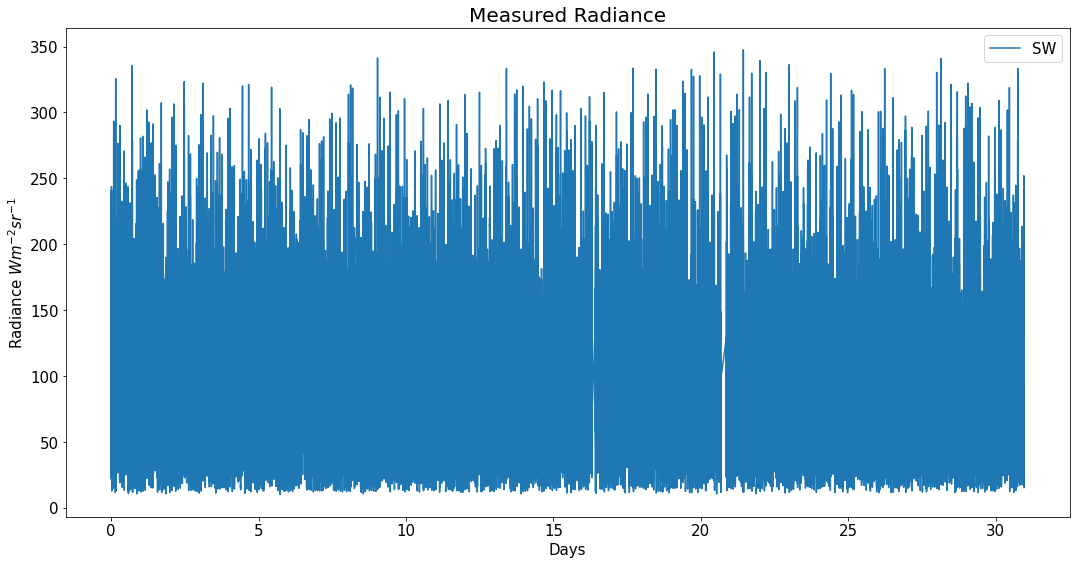

In [7]:
#Plot timesereies of SWrad and LWrad
#Times is Julian date which is just a big old number and it increases in units of days
    #Subtract all of times by the first time to just have time since start
times_days = df.Times_Julian - np.min(df.Times_Julian)    
    #Multiply by 24 so units are now in fraction of hr
#times_hrs = times_days * 24

plt.figure(1, figsize = (18,9))
plt.plot(times_days, df.SWrad, label = 'SW')
#plt.plot(times_days, df.VZA, label = 'VZA')
plt.title('Measured Radiance', fontsize = 20)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Radiance $Wm^{-2} sr^{-1}$', fontsize = 15)
plt.legend(loc='upper right', prop={"size":15})
# Set tick font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)	

(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text major ticklabel objects>)

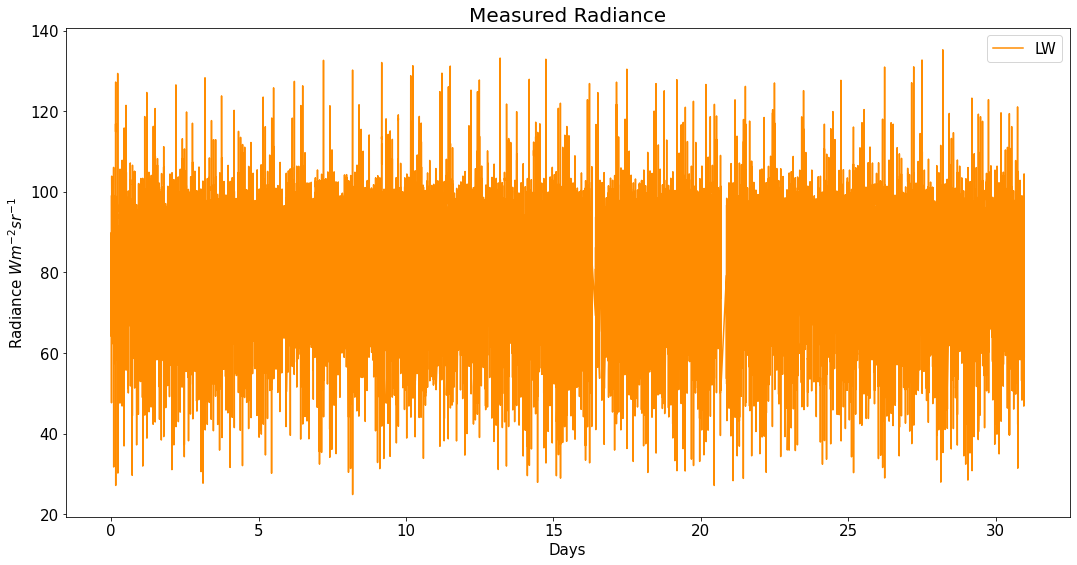

In [8]:
#Plot timesereies of SWrad and LWrad
#Times is Julian date which is just a big old number and it increases in units of days
    #Subtract all of times by the first time to just have time since start
times_days = df.Times_Julian - np.min(df.Times_Julian)    
    #Multiply by 24 so units are now in fraction of hr
#times_hrs = times_days * 24

plt.figure(1, figsize = (18,9))
#plt.plot(times_days, df.SWrad, label = 'SW')
plt.plot(times_days, df.LWrad, c='darkorange', label = 'LW')
#plt.plot(times_days, df.VZA, label = 'VZA')
plt.title('Measured Radiance', fontsize = 20)
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Radiance $Wm^{-2} sr^{-1}$', fontsize = 15)
plt.legend(loc='upper right', prop={"size":15})
#plt.ylim((0,350))
# Set tick font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)	

(array([-100.,  -75.,  -50.,  -25.,    0.,   25.,   50.,   75.,  100.]),
 <a list of 9 Text major ticklabel objects>)

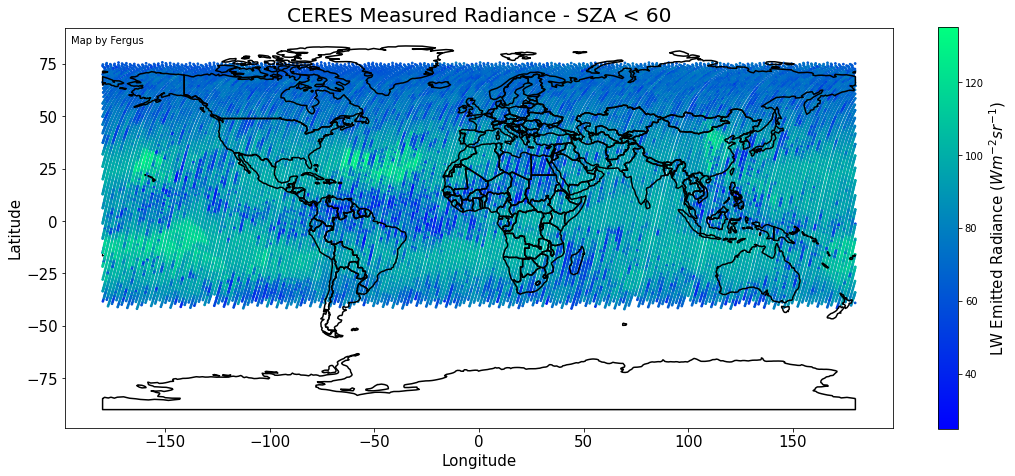

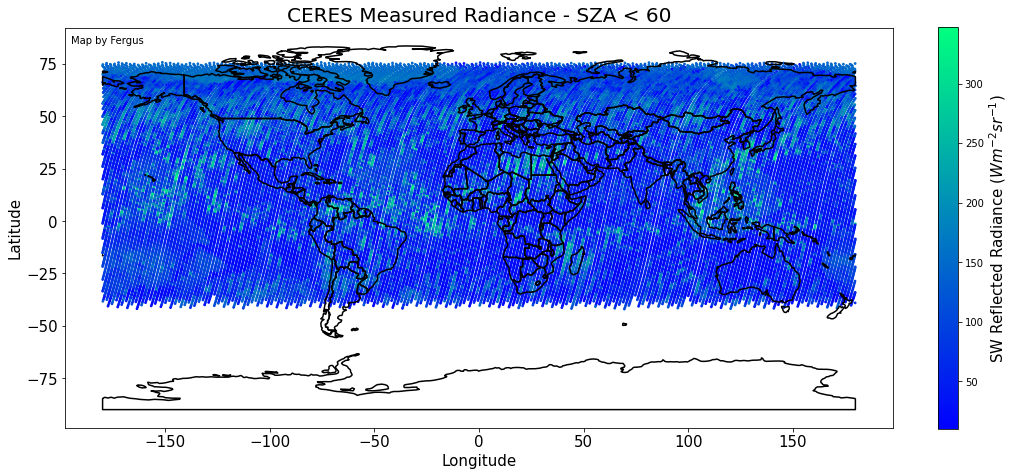

In [9]:
#Maps are fun
g_df = geo.GeoDataFrame(df)
path = geo.datasets.get_path('naturalearth_lowres')
geodf = geo.read_file(path)


fig = plt.figure(11, figsize = (16,8))
ax = fig.subplots()
ax = geodf.boundary.plot(ax=ax, color = 'k')
im = ax.scatter(df.Longitude, df.Latitude, c=df.LWrad, cmap = cm.winter, s = 3)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
ax.set_title('CERES Measured Radiance - SZA < 60', fontsize = 20)
cb = plt.colorbar(im, fraction = 0.0225)
cb.set_label(label = 'LW Emitted Radiance ($Wm^{-2} sr^{-1}$)', size = 15)
ax.text(-195,85, 'Map by Fergus')
# Set tick font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)	



fig = plt.figure(12, figsize = (16,8))
ax = fig.subplots()
ax = geodf.boundary.plot(ax=ax, color = 'k')
im = ax.scatter(df.Longitude, df.Latitude, c=df.SWrad, cmap = cm.winter, s = 3)
ax.set_xlabel('Longitude', fontsize=15)
ax.set_ylabel('Latitude', fontsize=15)
ax.set_title('CERES Measured Radiance - SZA < 60', fontsize = 20)
cb = plt.colorbar(im, fraction = 0.0225)
cb.set_label(label = 'SW Reflected Radiance ($Wm^{-2} sr^{-1}$)', size = 15)
ax.text(-195,85, 'Map by Fergus')
# Set tick font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)	

###**Step 3/4: Apply Data Science Method / Visualize Result**

**Calculate Correlation Between SWrad and LWrad**

In [10]:
#Use stats.linregress to calculate correlation, print important variables

info = stats.linregress(df.SWrad, df.LWrad)
slope = info[0]
intercept = info[1]
r_value = info[2]
pvalue = info[3]
stderr = info[4]


print('')
print('Slope, a1:',round(slope,2))
print('Intercept, a0:', round(intercept,2))
print('R_Value:', round(r_value,2))
print('Percent variance explained:',round((r_value**2)*100,1),'%')


#Make a y=mx+b line for plotting
fit_x = np.arange(np.min(df.SWrad), np.max(df.SWrad),0.1);
fit_y = [];
for i in fit_x:
    fit_y.append(slope*i + intercept)


Slope, a1: -0.19
Intercept, a0: 98.49
R_Value: -0.69
Percent variance explained: 47.6 %


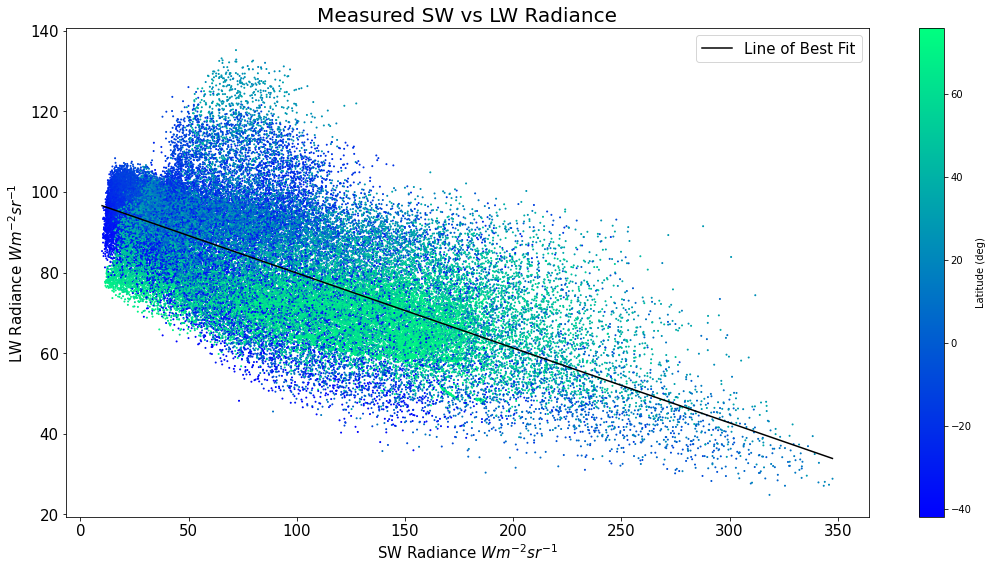

In [11]:
#Plot scatter plot with line of best fit
plt.figure(0, figsize = (18,9))
plt.scatter(df.SWrad, df.LWrad, c=df.Latitude, cmap = cm.winter, s = 1)
#plt.plot(xdata, bestline, 'k-', label = ('y = %sx + %s'%(eqn[0], eqn[1])))
plt.plot(fit_x,fit_y,c='black', label = 'Line of Best Fit');
#plt.plot(times_days, df.LWrad, label = 'LW')
#plt.plot(times_days, df.VZA, label = 'VZA')
plt.title('Measured SW vs LW Radiance', fontsize = 20)
plt.xlabel('SW Radiance $Wm^{-2} sr^{-1}$', fontsize = 15)
plt.ylabel('LW Radiance $Wm^{-2} sr^{-1}$', fontsize = 15)
plt.legend(loc='upper right', prop={"size":15})
# Set tick font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)	
plt.colorbar(label = 'Latitude (deg)')

**5. Test Hypothesis**

In [12]:
# Test null hypothesis: the true correlation is zero.
print('')
print('ASSESS SIGNIFICANCE OF REGRESSION Part 1: Using N')
print('Null Hypothesis: The true correlation is zero.')
N=len(df.SWrad)
print('N:',N)
#dof=N-2 
#print("dof= ",dof)
tcrit=stats.t.ppf(0.975,N)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=np.abs(r_value)*np.sqrt(N)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis.')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis.')


ASSESS SIGNIFICANCE OF REGRESSION Part 1: Using N
Null Hypothesis: The true correlation is zero.
N: 69950
tcrit= 1.96
t= 252.1
Since t= 252.1 exceeds tcrit= 1.96  we can reject the null hypothesis.


Use lag1 autocorrelation to calculate number of independent samples in both variables


In [13]:
#We want to standardize data first to use autocorrelation equations from application lab 2
def standardize(raw_data):
    sample_mean = np.mean(raw_data)
    sample_std = np.std(raw_data)
    standardized_list = []
    for i in raw_data:
        standardized_list.append((i - sample_mean)/sample_std)
    return standardized_list

SW_stand=standardize(df.SWrad)
LW_stand=standardize(df.LWrad)

print('')
print('SW_stand mean: ', np.mean(SW_stand))
print('LW_stand mean: ', np.mean(LW_stand))
print('SW_stand Standard deviation: ', np.std(SW_stand))
print('LW_stand Standard deviation: ', np.std(LW_stand))
print('Data now standardized')


SW_stand mean:  -3.511371163653344e-15
LW_stand mean:  1.4895494892331822e-13
SW_stand Standard deviation:  1.000000000000001
LW_stand Standard deviation:  0.999999999999995
Data now standardized


In [14]:
# Calculate the autocorrelation using numpy dot for SWrad
n=len(SW_stand)
sigma=1
lag=1
alpha=np.dot(SW_stand[0:-1*lag],SW_stand[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'SW_stand autocorrelation:',round(alpha,3))
## calculate N*
sw_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('# of independent samples, N*: ',sw_nstar) 
print('')

# Calculate the autocorrelation using numpy dot for LWrad
n=len(LW_stand)
sigma=1
lag=1
alpha=np.dot(LW_stand[0:-1*lag],LW_stand[lag:])/(n-lag)/sigma**2 ## Barnes Chapter 2 Eq. 68 divided by the variance
print('lag',lag,'LW_stand autocorrelation:',round(alpha,3))
## calculate N*
lw_nstar=round((1-np.abs(alpha))/(1+np.abs(alpha))*n,0) ## Chapter 2 Barnes Eq. 88
print('# of independent samples, N*: ',lw_nstar) 

lag 1 SW_stand autocorrelation: 0.767
# of independent samples, N*:  9241.0

lag 1 LW_stand autocorrelation: 0.883
# of independent samples, N*:  4344.0


In [15]:
#Perform T test with N* = 4344
# Test null hypothesis: the true correlation is zero.
print('')
print('ASSESS SIGNIFICANCE OF REGRESSION METHOD #2: Using N*')
print('Null Hypothesis: The true correlation is zero.')
N=lw_nstar
print('N*: ', N)
tcrit=stats.t.ppf(0.975,N)  ## two-sided 95%
print('tcrit=',round(tcrit,2))
t=np.abs(r_value)*np.sqrt(N)/np.sqrt((1-r_value*r_value))
print('t=',round(t,2))
if t>tcrit:
  print('Since t=',round(t,2),'exceeds tcrit=',round(tcrit,2),' we can reject the null hypothesis.')
elif t<tcrit:
  print('Since t=',round(t,2),'does not exceed tcrit=',round(tcrit,2),' we cannot reject the null hypothesis.')


ASSESS SIGNIFICANCE OF REGRESSION METHOD #2: Using N*
Null Hypothesis: The true correlation is zero.
N*:  4344.0
tcrit= 1.96
t= 62.82
Since t= 62.82 exceeds tcrit= 1.96  we can reject the null hypothesis.


###**Summary**
Yay! We can confidently state that there is some type of correlation between Sw radiance and LW radiance. However, this is just the beginning of much more  statistical analysis of this correlation that we could do next. Based on how confident our t-test was, I would assume that if we tested that the correlation is negative, we would fail to reject that hypothesis. Another next step would be to calculate confidence intervals on the line of best fit, so we can have bounds on the slope that could be used to predict LW radiance based on SW radiance. Also, I would next think of ways to limit the data even more, with the hope of improving the correlation. For example, I would try to remove any influence of clouds somehow, so that the radiance values are only due to surface reflectance and temperature. The possibilities with what to do next are endless!

References:
1. Loeb, N., Lyman, J., Johnson, G. et al. Observed changes in top-of-the-atmosphere radiation and upper-ocean heating consistent within uncertainty. Nature Geosci 5, 110–113 (2012). https://doi.org/10.1038/ngeo1375 
2. https://www.nesdis.noaa.gov/current-satellite-missions/currently-flying/joint-polar-satellite-system/jpss-mission-and-1
3. https://asdc.larc.nasa.gov/data/CERES/SSF/NPP-FM5-VIIRS_Edition1A/